In [1]:
import pandas as pd
import numpy as np
from slidevips.torch_datasets import SlideDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
SLIDE_DATAFRAME_PATH = ""  #unclean slide_dataframe_path
DATAFRAME_PATH = ""
EMBEDDING_PATH = ""
ARTEFACT_PERCENTAGES_PATH = ""

CLEAN_DATAFRAME_PATH = ""

In [3]:
slide_dataframe = pd.read_csv(SLIDE_DATAFRAME_PATH)
dataframe = pd.read_csv(DATAFRAME_PATH)
embeddings = np.load(EMBEDDING_PATH)
artifact_percentages = np.load(ARTEFACT_PERCENTAGES_PATH)

## H&E Artifact detection

In [4]:
dataset = SlideDataset(slide_dataframe, dataframe)

In [5]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=100, random_state=0).fit(embeddings)
cluster_idxs = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [6]:
def plot_cluster_images(cluster_idx, kmeans, embeddings, dataset, top_k=10, random_k=10):
    """
    Plot top-K closest to centroid (row 1) and K random from same cluster (row 2).
    Uses numpy for random sampling.
    """
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    cluster_mask = np.where(cluster_labels == cluster_idx)[0]
    cluster_embeddings = embeddings[cluster_mask]

    centroid = cluster_centers[cluster_idx]
    distances = np.linalg.norm(cluster_embeddings - centroid, axis=1)

    top_indices = cluster_mask[np.argsort(distances)[:top_k]]

    if len(cluster_mask) > random_k:
        remaining = np.setdiff1d(cluster_mask, top_indices)
        random_indices = np.random.choice(remaining, size=random_k, replace=False)
    else:
        random_indices = np.random.choice(cluster_mask, size=random_k, replace=True)

    fig, axes = plt.subplots(2, top_k, figsize=(top_k * 2, 4))
    for i, idx in enumerate(top_indices):
        img = dataset[idx]["image"].permute((1, 2, 0)).numpy()
        axes[0, i].imshow(img.astype(np.uint8))
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Top {i+1}")

    for i, idx in enumerate(random_indices):
        img = dataset[idx]["image"].permute((1, 2, 0)).numpy()
        axes[1, i].imshow(img.astype(np.uint8))
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Rand {i+1}")

    fig.suptitle(f"Cluster {cluster_idx} — Top {top_k} & Random {random_k}")
    plt.tight_layout()
    plt.show()

In [ ]:
cluster_idx = 0

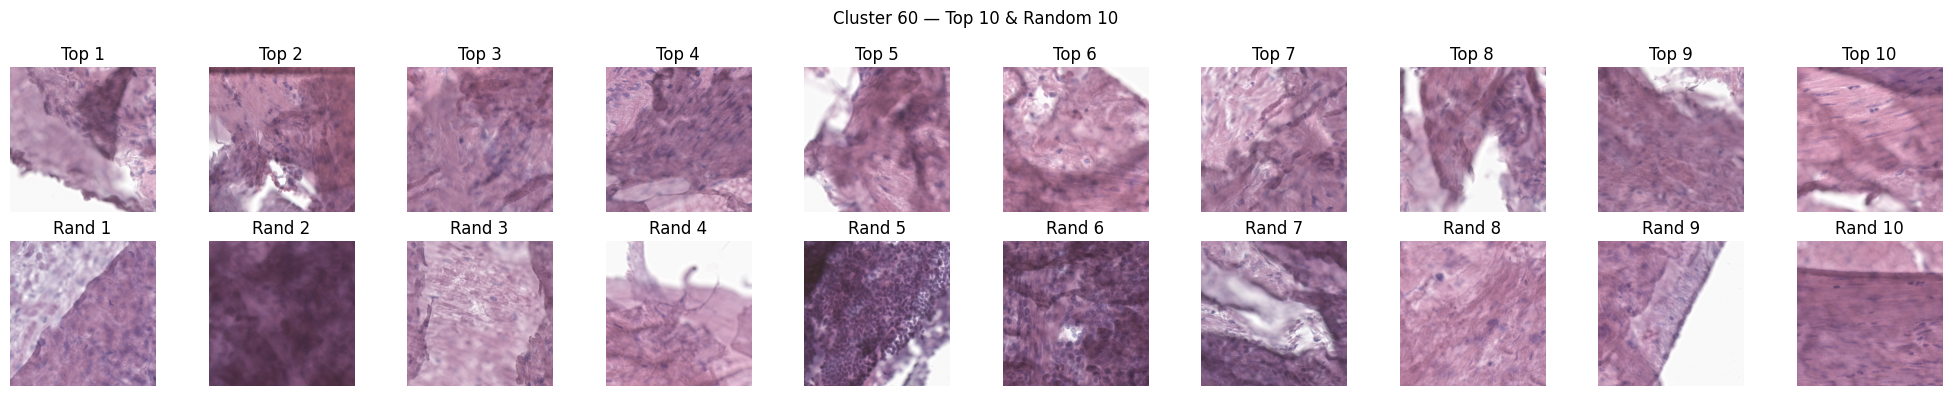

In [ ]:
plot_cluster_images(cluster_idx, kmeans, embeddings, dataset)
cluster_idx += 1

In [7]:
artifact_idxs = [17, 38, 60, 90, 98]

## IF Artifacts Detection

In [8]:
slide_dataframe_if = slide_dataframe.copy()
slide_dataframe_if["in_slide_path"] = slide_dataframe_if["targ_slide_path"]

In [9]:
from skimage.filters import threshold_triangle

ARTIFACT_CHANNEL_IDX = 5
ARTIFACT_PERCENT_THRESHOLD = 0.01
ARTIFACT_THRESHOLD = 2000

In [10]:
dataset = SlideDataset(slide_dataframe_if, dataframe,
                       mode="IF", channel_idxs=[ARTIFACT_CHANNEL_IDX], scale_factor=1.)

In [11]:
remove_idxs = np.argwhere(artifact_percentages > ARTIFACT_PERCENT_THRESHOLD).flatten()
keep_idxs = np.argwhere(artifact_percentages < ARTIFACT_PERCENT_THRESHOLD).flatten()

min_percent = ARTIFACT_PERCENT_THRESHOLD - 0.005
max_percent = ARTIFACT_PERCENT_THRESHOLD + 0.005
limit_idxs = np.argwhere((min_percent < artifact_percentages) & (artifact_percentages < max_percent)).flatten()

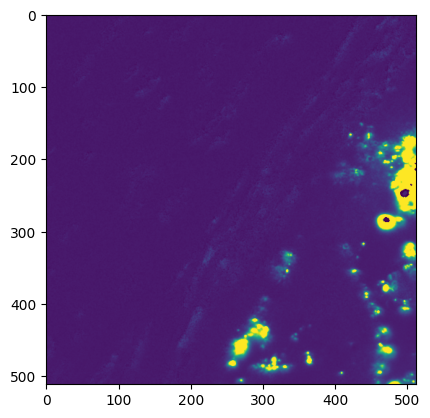

In [97]:
data = dataset[np.random.choice(remove_idxs)]
plt.imshow(data["image"][0], vmin=0, vmax=3000)

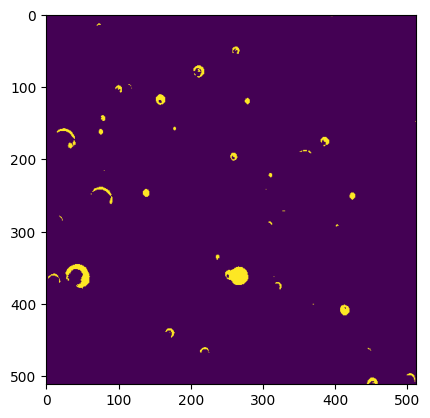

In [93]:
plt.imshow(data["image"][0] > ARTIFACT_THRESHOLD)

tensor(0.0132)


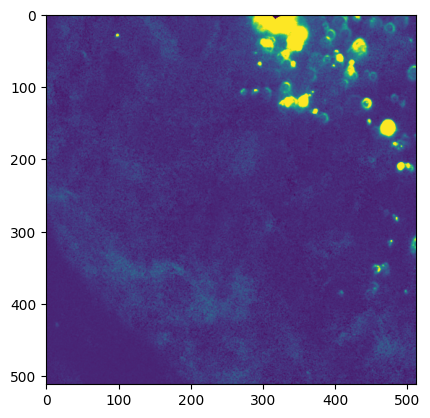

In [98]:
data = dataset[np.random.choice(limit_idxs)]
print((data["image"][0] > ARTIFACT_THRESHOLD).float().mean())
plt.imshow(data["image"][0], vmin=0, vmax=2000)

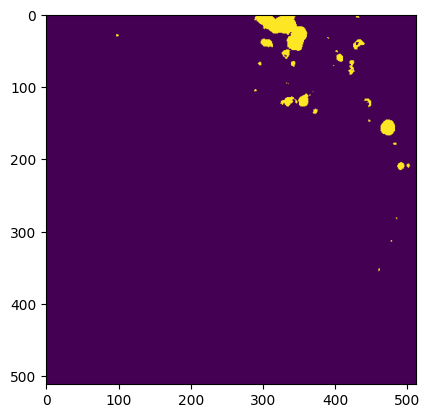

In [99]:
plt.imshow(data["image"][0] > ARTIFACT_THRESHOLD)

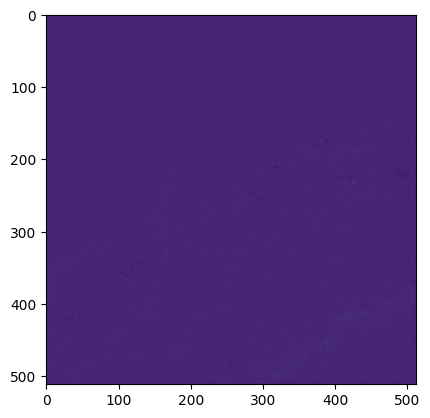

In [104]:
data = dataset[np.random.choice(keep_idxs)]
plt.imshow(data["image"][0], vmin=0, vmax=2000)

## Filter Artifacts from tile Dataframe

In [12]:
mask_he_artifacts = np.isin(cluster_idxs, artifact_idxs)
mask_if_artifacts = artifact_percentages > ARTIFACT_PERCENT_THRESHOLD
mask_keep = ~mask_he_artifacts & ~mask_if_artifacts

dataframe = dataframe[mask_keep]
dataframe.to_csv(CLEAN_DATAFRAME_PATH, index=False)